## Schritt 1 – Installation & Setup (BirdNET)

**BirdNET** ist ein Deep-Learning-Modell zur automatischen Erkennung von Vogelstimmen in Audiodaten.  
**BirdNET-Analyzer** ist das Tool für die Analyse einzelner Dateien oder ganzer Ordner und erzeugt Ergebnis-Tabellen
(z. B. CSV) mit **Zeitstempeln, Artenlabels und Confidence-Scores**.

In diesem Workshop installieren wir zuerst die System-Tools (z. B. `ffmpeg`) und anschließend BirdNET.


In [4]:
# ============================================
# Schritt 1: Installation & Setup (Colab)
# - System: ffmpeg + libsndfile1
# - Python: pandas, matplotlib, soundfile
# - BirdNET: zuerst birdnet-analyzer, sonst birdnet (Fallback)
# ============================================

import sys, subprocess, importlib.util

# ---------- Helper: robustes pip install ----------
def pip_install(*packages, upgrade=False):
    """Installiert Pakete über pip (ohne Cache, offizielles PyPI)."""
    cmd = [
        sys.executable, "-m", "pip", "install",
        "--no-cache-dir",
        "-i", "https://pypi.org/simple"
    ]
    if upgrade:
        cmd.append("-U")
    cmd += list(packages)
    subprocess.check_call(cmd)

def ensure(import_name: str, pip_name: str | None = None):
    """Installiert via pip nur dann, wenn Import fehlt."""
    if importlib.util.find_spec(import_name) is None:
        pip_install(pip_name or import_name)
        print(f"Installed: {pip_name or import_name} ✅")
    else:
        print(f"OK: {import_name} already available ✅")

# ---------- System-Pakete ----------
print("Installing system deps (ffmpeg, libsndfile1)...")
subprocess.check_call(["bash", "-lc", "apt-get -qq update"])
subprocess.check_call(["bash", "-lc", "apt-get -qq install -y ffmpeg libsndfile1"])

# ---------- pip tooling aktualisieren (optional, aber hilfreich) ----------
print("Upgrading pip tooling...")
try:
    pip_install("pip", "setuptools", "wheel", upgrade=True)
    print("pip tooling upgraded ✅")
except Exception as e:
    print("pip tooling upgrade skipped (not critical). Reason:", str(e)[:200], "...")

# ---------- Basis-Pakete ----------
print("Installing/Checking base Python libs...")
ensure("pandas")
ensure("matplotlib")
ensure("soundfile", "soundfile")

# ---------- BirdNET installieren ----------
print("Installing BirdNET...")

BN_MODE = None
try:
    pip_install("birdnet-analyzer")
    BN_MODE = "analyzer"
    print("Installed: birdnet-analyzer ✅")
except Exception as e:
    print("birdnet-analyzer install failed -> fallback to 'birdnet'")
    print("Reason:", str(e)[:200], "...")
    pip_install("birdnet")
    BN_MODE = "birdnet"
    print("Installed: birdnet (fallback) ✅")

print("\nDone.")
print("Python:", sys.version.split()[0])
print("BN_MODE:", BN_MODE)


Installing system deps (ffmpeg, libsndfile1)...
Upgrading pip tooling...
pip tooling upgraded ✅
Installing/Checking base Python libs...
OK: pandas already available ✅
OK: matplotlib already available ✅
OK: soundfile already available ✅
Installing BirdNET...
Installed: birdnet-analyzer ✅

Done.
Python: 3.12.12
BN_MODE: analyzer


## Schritt 2 – Upload in 2 Teilen (erst Artenliste, dann Audio)

Bitte lade die Dateien **nacheinander** hoch:

1. **Artenliste** als `.txt` (oder `.csv`) – **eine Art pro Zeile**
2. **Audiodatei** (AudioMoth: `.WAV/.wav`)

**Warum getrennt?**  
Damit im Workshop klar ist, was zuerst kommt, und damit der Code sauber prüft, ob wirklich beide Dateien vorhanden sind.

**Ergebnis nach Schritt 2:**
- `species_list` = Arten aus der TXT-Datei (bereinigt, eindeutig, sortiert)
- `audio_path` = hochgeladene Audiodatei


In [6]:
# ============================================
# Schritt 2: Upload in 2 Teilen
# 1) Artenliste hochladen (.txt/.csv)
# 2) Audiodatei hochladen (.wav/.WAV/...)
# ============================================

from google.colab import files

# ---------- Teil 1: Artenliste hochladen ----------
print("TEIL 1/2: Bitte JETZT die Artenliste (.txt oder .csv) hochladen")
uploaded_list = files.upload()

list_files = list(uploaded_list.keys())
if len(list_files) == 0:
    raise ValueError("Keine Datei hochgeladen (Artenliste).")

# Nimm die erste passende Datei
list_exts = (".txt", ".TXT", ".csv", ".CSV")
species_path = next((f for f in list_files if f.endswith(list_exts)), None)
if species_path is None:
    raise ValueError("Das war keine .txt/.csv. Bitte lade die Artenliste als .txt oder .csv hoch.")

print("Artenliste erkannt:", species_path)

# Artenliste einlesen (eine Art pro Zeile)
species_list = []
with open(species_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        s = line.strip()
        if not s or s.startswith("#"):
            continue
        # falls "Art;Notiz" oder "Art, Notiz" -> nur erstes Feld
        s = s.split(";")[0].split(",")[0].strip()
        if s:
            species_list.append(s)

species_list = sorted(set(species_list))
print("Species loaded:", len(species_list))
print("First 15 species:", species_list[:15])

# ---------- Teil 2: Audio hochladen ----------
print("\nTEIL 2/2: Bitte JETZT die Audiodatei hochladen (.wav/.WAV etc.)")
uploaded_audio = files.upload()

audio_files = list(uploaded_audio.keys())
if len(audio_files) == 0:
    raise ValueError("Keine Datei hochgeladen (Audio).")

audio_exts = (".wav", ".WAV", ".mp3", ".flac", ".ogg", ".m4a")
audio_path = next((f for f in audio_files if f.endswith(audio_exts)), None)
if audio_path is None:
    raise ValueError("Keine Audiodatei erkannt. Bitte lade eine .wav/.WAV (oder mp3/flac/ogg/m4a) hoch.")

print("Audio erkannt:", audio_path)


TEIL 1/2: Bitte JETZT die Artenliste (.txt oder .csv) hochladen


Saving Arten_NRW.txt to Arten_NRW.txt
Artenliste erkannt: Arten_NRW.txt
Species loaded: 389
First 15 species: ['Acanthis cabaret', 'Acanthis flammea', 'Acanthis hornemanni', 'Accipiter gentilis', 'Accipiter nisus', 'Acrocephalus agricola', 'Acrocephalus arundinaceus', 'Acrocephalus dumetorum', 'Acrocephalus paludicola', 'Acrocephalus palustris', 'Acrocephalus schoenobaenus', 'Acrocephalus scirpaceus', 'Actitis hypoleucos', 'Actitis macularius', 'Aegithalos caudatus']

TEIL 2/2: Bitte JETZT die Audiodatei hochladen (.wav/.WAV etc.)


Saving GroupA_mix.wav to GroupA_mix (1).wav
Audio erkannt: GroupA_mix (1).wav


## Schritt 3A – BirdNET Analyse (ohne Artenlisten-Filter)

In diesem Schritt führen wir BirdNET auf der vorbereiteten Audiodatei aus und speichern die Ergebnisse als **CSV**.

Wichtig:
- Wir starten **ohne `--slist`**, weil ein falsches Artenlisten-Format sonst alle Treffer herausfiltern kann.
- Für den Workshop setzen wir oft einen eher niedrigen `min_conf` (z. B. `0.05`) und eine etwas höhere `sensitivity`,
  damit überhaupt ausreichend Detektionen sichtbar werden.

**Ergebnis nach Schritt 3A:**
- `df_all` enthält alle Detektionen (inkl. Scientific name, Common name, Confidence, Zeitfenster).
- Die kombinierte Ergebnisdatei liegt als `BirdNET_CombinedTable.csv` im Ordner `/content/birdnet_out/`.


In [12]:
import os, shutil, subprocess
import pandas as pd

out_dir = "/content/birdnet_out"
wav_path = "/content/audio/input.wav"

# Optional: sicherstellen, dass wir den Analyzer nutzen
if "BN_MODE" in globals() and BN_MODE != "analyzer":
    raise RuntimeError(f"BN_MODE ist '{BN_MODE}'. Dieses Step-3A Skript erwartet BN_MODE='analyzer'.")

# Output-Ordner neu
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
os.makedirs(out_dir, exist_ok=True)

# Workshop-freundliche Parameter
MIN_CONF = 0.05
SENSITIVITY = 1.25
TOP_N = 5
THREADS = 2
LOCALE = "de"

cmd = (
    f'python -m birdnet_analyzer.analyze "{wav_path}" '
    f'-o "{out_dir}" '
    f'--rtype csv --combine_results '
    f'--min_conf {MIN_CONF} --sensitivity {SENSITIVITY} --top_n {TOP_N} '
    f'-t {THREADS} -l {LOCALE} '
)

print("Command:\n", cmd)

res = subprocess.run(cmd, shell=True, text=True, capture_output=True)
print(res.stdout)
if res.returncode != 0:
    print(res.stderr)
    raise RuntimeError("BirdNET-Analyzer failed.")

csv_path = "/content/birdnet_out/BirdNET_CombinedTable.csv"
df_all = pd.read_csv(csv_path)

print("Rows (all):", len(df_all))
display(df_all.head(10))

if len(df_all) == 0:
    print("\n⚠️ Keine Detektionen. Tipps:")
    print("- MIN_CONF testweise auf 0.02 oder 0.01 senken")
    print("- SENSITIVITY erhöhen (z. B. 1.5)")


Command:
 python -m birdnet_analyzer.analyze "/content/audio/input.wav" -o "/content/birdnet_out" --rtype csv --combine_results --min_conf 0.05 --sensitivity 1.25 --top_n 5 -t 2 -l de 
Model found!
Found 1 files to analyze
Species list contains 6522 species
Analyzing /content/audio/input.wav
Finished /content/audio/input.wav in 9.98 seconds
Combining results, writing to /content/birdnet_out...done!

Rows (all): 345


,Start (s),End (s),Scientific name,Common name,Confidence,File
0,0.0,3.0,Turdus merula,Amsel,0.9995,/content/audio/input.wav
1,0.0,3.0,Turdus mandarinus,Mandarinamsel,0.1545,/content/audio/input.wav
2,0.0,3.0,Turdus boulboul,Bülbülamsel,0.0780,/content/audio/input.wav
3,0.0,3.0,Turdus philomelos,Singdrossel,0.0403,/content/audio/input.wav
4,0.0,3.0,Turdus viscivorus,Misteldrossel,0.0255,/content/audio/input.wav
5,3.0,6.0,Turdus merula,Amsel,0.9997,/content/audio/input.wav
6,3.0,6.0,Turdus philomelos,Singdrossel,0.7757,/content/audio/input.wav
7,3.0,6.0,Turdus viscivorus,Misteldrossel,0.4121,/content/audio/input.wav
8,3.0,6.0,Turdus boulboul,Bülbülamsel,0.0645,/content/audio/input.wav
9,3.0,6.0,Turdus hortulorum,Amurdrossel,0.0460,/content/audio/input.wav


## Schritt 3B – Filter auf eure Artenliste (nach der Analyse)

Jetzt filtern wir die BirdNET-Ergebnisse **nachträglich** mit eurer hochgeladenen Artenliste.

Warum nachträglich?
- Eure TXT-Datei kann korrekt sein (z. B. wissenschaftliche Namen), aber BirdNETs `--slist` erwartet je nach Version
  ein spezielles Label-Format. Nachträgliches Filtern ist im Workshop robuster und transparenter.

So filtern wir:
- Match auf **Scientific name** (und zusätzlich optional auf **Common name**, falls eure Liste mal deutsche Namen enthält).

**Ergebnis nach Schritt 3B:**
- `df_filtered` enthält nur Detektionen, deren Art in eurer Liste steht.
- Zusätzlich speichern wir `birdnet_results_filtered.csv` nach `/content/birdnet_out/`.
Hinweis: Wenn die Artenliste nicht zur Aufnahme passt, kann `df_filtered` auch leer sein – das ist dann kein Fehler.


In [13]:
# ============================================
# Schritt 3B: Ergebnisse auf Artenliste filtern
# Voraussetzung: df_all (aus Schritt 3A), species_list (aus Schritt 2)
# ============================================

import pandas as pd

# Spalten aus deiner CSV:
SCI_COL = "Scientific name"
COM_COL = "Common name"
CONF_COL = "Confidence"

# Normalisieren (lowercase)
wanted = {s.strip().lower() for s in species_list}

df_all["_sci_norm"] = df_all[SCI_COL].astype(str).str.strip().str.lower()
df_all["_com_norm"] = df_all[COM_COL].astype(str).str.strip().str.lower()

# Filter: match auf scientific ODER common name (falls eure Liste doch mal deutsche Namen enthält)
mask = df_all["_sci_norm"].isin(wanted) | df_all["_com_norm"].isin(wanted)
df_filtered = df_all[mask].copy()

# Aufräumen
df_all.drop(columns=["_sci_norm", "_com_norm"], inplace=True)
df_filtered.drop(columns=["_sci_norm", "_com_norm"], errors="ignore", inplace=True)

print("Rows (all):", len(df_all))
print("Rows (filtered):", len(df_filtered))

# Quick-Check: welche Arten sind im Audio?
print("\nTop 10 im Audio (ungefiltert):")
display(df_all[SCI_COL].value_counts().head(10))

# Quick-Check: welche eurer Listenarten kommen vor?
if len(df_filtered) == 0:
    print("\n⚠️ Keine Treffer nach Filter. (Artenliste passt evtl. nicht zur Aufnahme.)")
else:
    print("\nTreffer nach Filter (Top 10):")
    display(df_filtered[SCI_COL].value_counts().head(10))

# Gefilterte CSV speichern
filtered_csv = "/content/birdnet_out/birdnet_results_filtered.csv"
df_filtered.to_csv(filtered_csv, index=False)
print("Saved:", filtered_csv)


Rows (all): 345
Rows (filtered): 277

Top 10 im Audio (ungefiltert):


,count
Scientific name,
Turdus merula,27
Turdus philomelos,25
Erithacus rubecula,17
Phoenicurus phoenicurus,15
Parus major,14
Sylvia atricapilla,13
Turdus viscivorus,11
Phylloscopus ibericus,9
Luscinia megarhynchos,9



Treffer nach Filter (Top 10):


,count
Scientific name,
Turdus merula,27
Turdus philomelos,25
Erithacus rubecula,17
Phoenicurus phoenicurus,15
Parus major,14
Sylvia atricapilla,13
Turdus viscivorus,11
Phylloscopus collybita,9
Luscinia megarhynchos,9


Saved: /content/birdnet_out/birdnet_results_filtered.csv


## Schritt 4 – Visualisierung (Workshop-Plots)

Wir erstellen mehrere Plots, die in Workshops schnell verständlich sind:

1. **Top-Arten nach Häufigkeit**  
   → Welche Arten wurden am häufigsten detektiert?

2. **Median-Confidence pro Art** (für die Top-Arten)  
   → Welche Arten werden besonders „sicher“ erkannt?

3. **Confidence-Verteilung pro Art (Boxplot)**  
   → Wie stabil sind die Confidence-Scores (Streuung, Ausreißer)?

4. **Detektionen über die Zeit** (Histogramm über Start-Zeitfenster)  
   → In welchen Abschnitten des Audios passiert am meisten?

5. **Spektrogramm / Sonogramm** (Ausschnitt der Audiodatei)  
   → Visueller „Aha“-Effekt: Vogelstimmen vs. Hintergrundgeräusche.

Hinweis: BirdNET liefert einen **Confidence-Score (0–1)** pro Detektion.  
Das ist kein statistisches Konfidenzintervall, aber wir können die **Verteilung** der Confidence-Werte sehr gut plotten.


Rows used for plots: 277


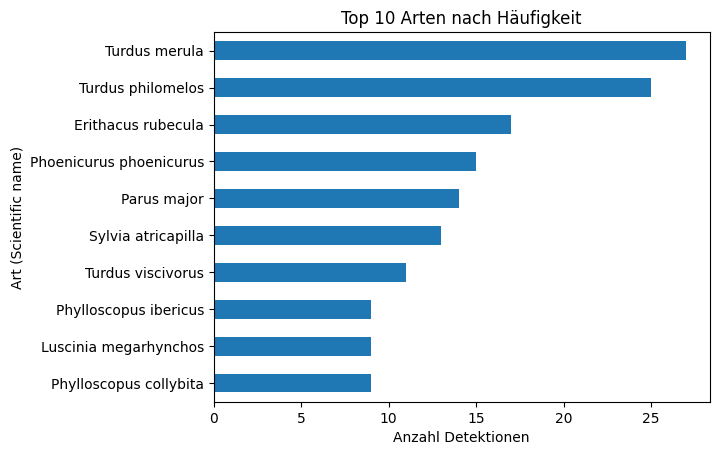

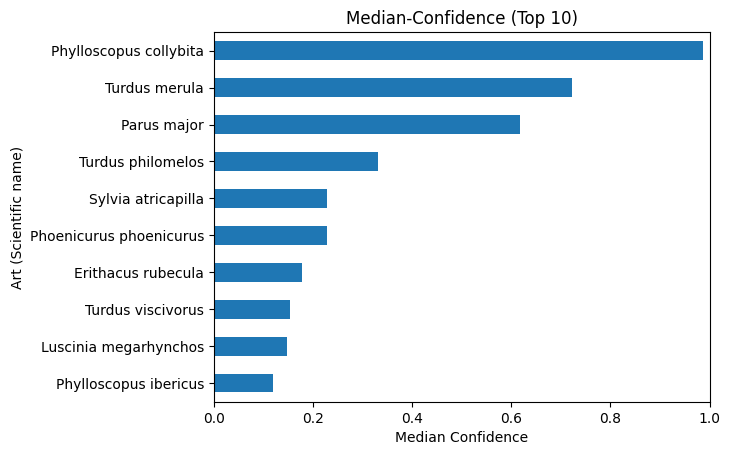

/tmp/ipython-input-3816600816.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


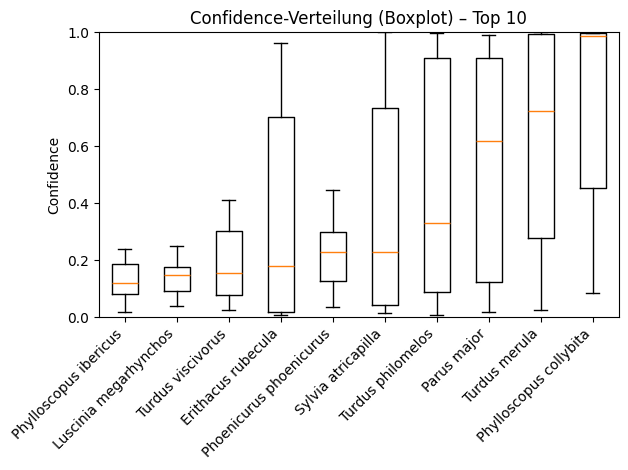

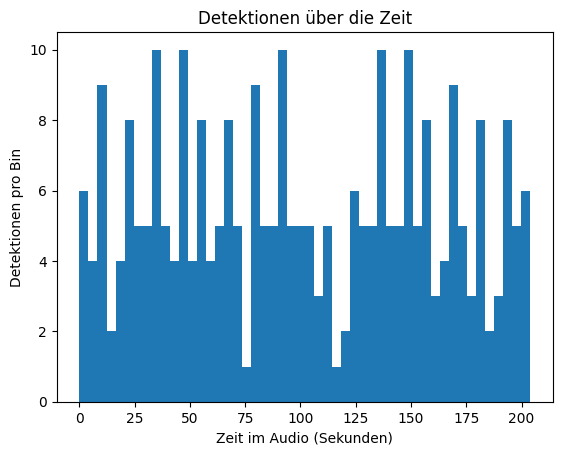

/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


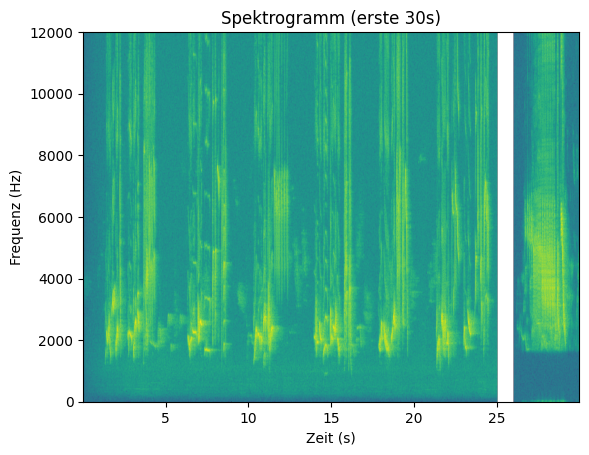

In [14]:
# ============================================
# Schritt 4: Plots
# - nutzt df_filtered, wenn nicht leer, sonst df_all
# ============================================

import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

SCI_COL = "Scientific name"
COM_COL = "Common name"
CONF_COL = "Confidence"
START_COL = "Start (s)"

df_plot = df_filtered if "df_filtered" in globals() and len(df_filtered) > 0 else df_all
print("Rows used for plots:", len(df_plot))

# ---- Plot 1: Top 10 Arten nach Häufigkeit ----
top_n = 10
counts = df_plot[SCI_COL].astype(str).value_counts().head(top_n).sort_values(ascending=True)

plt.figure()
counts.plot(kind="barh")
plt.xlabel("Anzahl Detektionen")
plt.ylabel("Art (Scientific name)")
plt.title(f"Top {top_n} Arten nach Häufigkeit")
plt.show()

# ---- Plot 2: Median-Confidence pro Art (Top 10 nach Häufigkeit) ----
top_species = counts.index.tolist()
sub = df_plot[df_plot[SCI_COL].astype(str).isin(top_species)].copy()

med = sub.groupby(SCI_COL)[CONF_COL].median().sort_values(ascending=True)

plt.figure()
med.plot(kind="barh")
plt.xlabel("Median Confidence")
plt.ylabel("Art (Scientific name)")
plt.title(f"Median-Confidence (Top {top_n})")
plt.xlim(0, 1)
plt.show()

# ---- Plot 3: Boxplot Confidence-Verteilung (Top 10) ----
data = [sub[sub[SCI_COL].astype(str) == sp][CONF_COL].dropna().values for sp in med.index.tolist()]
labels = [str(sp) for sp in med.index.tolist()]

plt.figure()
plt.boxplot(data, labels=labels, showfliers=False)
plt.ylabel("Confidence")
plt.title(f"Confidence-Verteilung (Boxplot) – Top {top_n}")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---- Plot 4: Detektionen über Zeit (Histogramm) ----
x = pd.to_numeric(df_plot[START_COL], errors="coerce").dropna().values
if len(x) > 0:
    plt.figure()
    plt.hist(x, bins=50)
    plt.xlabel("Zeit im Audio (Sekunden)")
    plt.ylabel("Detektionen pro Bin")
    plt.title("Detektionen über die Zeit")
    plt.show()

# ---- Plot 5: Spektrogramm (erste 30 Sekunden) ----
wav_path = "/content/audio/input.wav"
audio, sr = sf.read(wav_path)
if audio.ndim > 1:
    audio = audio.mean(axis=1)

max_seconds = 30
segment = audio[:min(len(audio), int(sr * max_seconds))]

plt.figure()
plt.specgram(segment, NFFT=2048, Fs=sr, noverlap=1024)
plt.xlabel("Zeit (s)")
plt.ylabel("Frequenz (Hz)")
plt.title(f"Spektrogramm (erste {max_seconds}s)")
plt.ylim(0, 12000)
plt.show()
